In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

### Data

In [2]:
df = pd.read_csv('data_20180119_20180420.csv', index_col=0)
df.head()

,t0,T1,K1,C1,T2,K2,C2,S0,Adj_S0
0,2018-01-02,2018-01-19,1000.0,191.525,2018-04-20,800.0,396.725000,59.4505,1189.01001
1,2018-01-02,2018-01-19,1100.0,92.525,2018-04-20,1015.0,191.675000,59.4505,1189.01001
2,2018-01-02,2018-01-19,1150.0,46.075,2018-04-20,1025.0,183.025000,59.4505,1189.01001
3,2018-01-02,2018-01-19,1160.0,38.000,2018-04-20,1050.0,157.776341,59.4505,1189.01001
4,2018-01-02,2018-01-19,1170.0,30.450,2018-04-20,1080.0,137.850000,59.4505,1189.01001


In [3]:
S0 = df['Adj_S0'].unique()

In [4]:
t0List = list(df.t0.unique())

# dimension: K[k-th t0][t1 and t2][i-th option with i-th strike]
K = [[np.array(df.loc[df.t0 == t0,'K1']),np.array(df.loc[df.t0==t0,'K2'])] for t0 in t0List]

# dimension: Pi[k-th t0][t1 and t2][i-th option with i-th price]
Pi = [[np.array(df.loc[df.t0 == t0,'C1']),np.array(df.loc[df.t0==t0,'C2'])] for t0 in t0List]

In [5]:
# number of t0
N_t0 = len(t0List)

# number of times (t1, t2)
T = 2

# number of options in hedging
N1, N2 = 20, 20
Size = max(N1, N2)

In [6]:
# Assume marginal distribution is uniform
def margDistr(batch_size):
    data = np.random.uniform(size=(N_t0, batch_size, T))
    eps = 500
    for i in range(N_t0):
        for t in range(T):
            data[i,:,t] = (S0[i]-eps) + 2*eps*data[i,:,t]
    return data

When try with eps = 100, the prices will become negative. When try with eps = 500, the prices will become positive. Guess there is something to do with the range of simulated stock prices.

In [7]:
BATCH_SIZE = 1000
S = margDistr(BATCH_SIZE)

# different S for different t0: 13*Batch_size*2

In [39]:
Phi = (S[:,:,1]-S[:,:,0])
# define the payoff function of the derivative

### Variables

In [58]:
# parameter: d
d = tf.Variable(
    initial_value = tf.random.normal(shape=[N_t0, 1], dtype=tf.float64),
    trainable = True,
    name = 'd'
)

In [59]:
# parameter: lambda
Lambda = tf.Variable(
    initial_value = tf.random.normal(shape=[N_t0, T, Size], dtype=tf.float64),
    trainable = True,
    name = 'lambda'
)

In [60]:
# parameter: Delta_0
Delta_0 = tf.Variable(
    initial_value = tf.random.normal(shape=[N_t0, 1], dtype=tf.float64),
    trainable = True,
    name = 'Delta0'
)

In [61]:
# neural network: Delta_1(S_1)
Delta_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(BATCH_SIZE,)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(N_t0, activation='linear', dtype=tf.float64)
])

### The step-by-step computation of the objective function

$d+\sum_{i=1}^{N_1}\lambda_{i,1}\Pi_{i,1}+\sum_{i=1}^{N_2}\lambda_{i,2}\Pi_{i,2}$

In [44]:
hedgePrice = []
for n in range(N_t0):
    p = d[n]
    for t in range(T):
        p += tf.reduce_sum(Lambda[n,t,:]*Pi[n][t][:])
    hedgePrice.append(p)

In [45]:
# take a look
hedgePrice

[<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-694.4188551])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1086.38854019])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-98.91195903])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([583.48130139])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-180.7651195])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1348.32406814])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-90.98803397])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-657.05877686])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([829.03574485])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-8.19687209])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-451.05392946])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-163.84130623])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([113.87811018])>]

$d+\sum_{i=1}^{N_1}\lambda_{i,1}(S_1-K_{i,1})^++\sum_{i=1}^{N_2}\lambda_{i,2}(S_2-K_{i,2})^++\Delta_{0}\cdot(S_1-S_0)+\Delta_{1}(S_1)\cdot(S_2-S_1)$

In [15]:
# one more variable Delta_0 Delta_0(S1-S0)

In [46]:
hedgeTerm = []
for n in range(N_t0):
    p = d[n]
    for t in range(T):
        p += tf.reduce_sum(Lambda[n,t,:]*tf.maximum(S[n,:,t].reshape(BATCH_SIZE,1)-K[n][t][:],0),axis=1)
    p += Delta_0[n,0]*(S[n,:,0]-S0[n])
    p += Delta_1(S[n,:,0].reshape((1,-1)))[0,n]*(S[n,:,1]-S[n,:,0])
    hedgeTerm.append(p)

In [47]:
# take a look
hedgeTerm

[<tf.Tensor: shape=(1000,), dtype=float64, numpy=
 array([-3.67916653e+05, -2.05758299e+05, -1.53630826e+05,  1.97165771e+05,
        -6.96446609e+04, -2.20538244e+05, -4.74010506e+05,  1.11816666e+05,
        -6.71488207e+05, -5.56369652e+05, -6.09462781e+05,  2.05810647e+05,
         1.08718155e+05, -3.43769527e+04, -2.68496083e+05,  1.18208027e+05,
         5.46528155e+05, -5.00720307e+04,  2.12535888e+05, -1.56419671e+04,
         2.37807243e+05, -4.25516074e+05, -3.47073589e+05, -1.59004932e+05,
         6.72932291e+05, -5.90542000e+05,  5.95922664e+05,  4.45473489e+05,
        -6.61027651e+04, -9.30565158e+04, -4.13248645e+05,  6.59182014e+04,
        -4.76269390e+05, -6.51791677e+04, -1.28774316e+05,  2.74300367e+05,
         2.36428236e+05, -2.64982910e+05, -1.99675337e+05, -2.69451444e+04,
        -3.62076543e+05,  2.96521605e+04, -4.29865557e+05, -2.61867222e+05,
         4.01841899e+05,  1.48443698e+05, -1.37208295e+05, -5.66661264e+05,
         1.13875857e+05,  7.52902059e+

$\inf_{h\in\mathcal{H}^m}\int hd\mu_0+\int \beta_\gamma(c-h)d\theta$

$d+\sum_{i=1}^{N_1}\lambda_{i,1}\Pi_{i,1}+\sum_{i=1}^{N_2}\lambda_{i,2}\Pi_{i,2} + \Gamma\cdot\left[\left(\Phi(S_1,S_2)-d-\sum_{i=1}^{N_1}\lambda_{i,1}(S_1-K_{i,1})^+-\sum_{i=1}^{N_2}\lambda_{i,2}(S_2-K_{i,2})^+-\Delta_{0}\cdot(S_1-S_0)-\Delta_{1}(S_1)\cdot(S_2-S_1)\right)^+\right]^2$

In [48]:
# objective function
Price = tf.reduce_mean(hedgePrice, axis=1)

Gamma = 100000
diff = Phi - tf.stack(hedgeTerm, axis=0)
Penalty = tf.reduce_mean(tf.square(tf.nn.relu(diff)), axis=1)

ObjFunc = Price + Gamma*Penalty

In [19]:
# take a look
Price

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([ 175.87098317,   56.8964642 , -138.93989588, -247.72883477,
       -343.88484623, -483.74898235,   -8.07874181,  145.65070357,
        381.48634137,  986.79032308,  792.29739315, -579.21630052,
       -341.23128033])>

In [20]:
# take a look
Penalty

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([4.79506153e+08, 2.16103235e+11, 1.41667799e+11, 2.22368754e+11,
       2.10266577e+10, 8.66040696e+06, 2.96146603e+10, 1.08470105e+10,
       1.65065424e+11, 3.25147050e+11, 1.75791996e+09, 6.16045633e+10,
       4.54454109e+09])>

In [21]:
# take a look
ObjFunc

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([4.79506153e+12, 2.16103235e+15, 1.41667799e+15, 2.22368754e+15,
       2.10266577e+14, 8.66040691e+10, 2.96146603e+14, 1.08470105e+14,
       1.65065424e+15, 3.25147050e+15, 1.75791996e+13, 6.16045633e+14,
       4.54454109e+13])>

### Optimisation

In [65]:
# Combine all the computation as a function
def ObjFunc(d, Lambda, Delta_0, Delta_1, K, Pi, Phi, S):
    hedgePrice = []
    for n in range(N_t0):
        p = d[n]
        for t in range(T):
            p += tf.reduce_sum(Lambda[n,t,:]*Pi[n][t][:])
        hedgePrice.append(p)
    
    hedgeTerm = []
    for n in range(N_t0):
        p = d[n]
        for t in range(T):
            p += tf.reduce_sum(Lambda[n,t,:]*tf.maximum(S[n,:,t].reshape(BATCH_SIZE,1)-K[n][t][:],0),axis=1)
        p += Delta_0[n,0]*(S[n,:,0]-S0[n])
        p += Delta_1(S[n,:,0].reshape((1,-1)))[0,n]*(S[n,:,1]-S[n,:,0])
        hedgeTerm.append(p)
    
    Price = tf.reduce_mean(hedgePrice, axis=1)
    Gamma = 10000
    diff = Phi-tf.stack(hedgeTerm, axis=0)
    Penalty = tf.reduce_mean(tf.square(tf.nn.relu(diff)), axis=1)
    
    return Price + Gamma*Penalty, Price, Penalty

In [63]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.01)

In [66]:
nIter = 10000
threshold = 1e-3
prev_price = tf.ones((N_t0,), dtype = tf.float64) * float('inf')

result_prices = pd.DataFrame()
result_penalty = pd.DataFrame()
for step in range(nIter):
    if (step+1) % 500 == 0:
        print("Processing progress: %d / %d" %(step+1, nIter))
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(d)
        tape.watch(Lambda)
        tape.watch(Delta_0)
        for variable in Delta_1.trainable_variables:
            tape.watch(variable)

        obj, price,penalty = ObjFunc(d, Lambda, Delta_0, Delta_1, K, Pi, Phi, S)
    gradients_d, gradients_Lambda, gradients_Delta_0 = tape.gradient(obj, [d, Lambda, Delta_0])
    gradients_Delta_1 = tape.gradient(obj, Delta_1.trainable_variables)
    
    optimizer.apply_gradients(
        zip([gradients_d, gradients_Lambda, gradients_Delta_0] + gradients_Delta_1, 
            [d, Lambda, Delta_0] + Delta_1.trainable_variables)
    )
    
    diff = tf.abs(price - prev_price)
    if tf.reduce_max(diff) < threshold:
        print("Converged at step", step+1)
        break
    prev_price = price
    if step >= 9000:
        result_prices = pd.concat([result_prices,pd.DataFrame(price.numpy(),columns=[str(step)]).T])
        result_penalty = pd.concat([result_penalty,pd.DataFrame(penalty.numpy(),columns=[str(step)]).T])
    del tape

Processing progress: 500 / 10000
Processing progress: 1000 / 10000
Processing progress: 1500 / 10000
Processing progress: 2000 / 10000
Processing progress: 2500 / 10000
Processing progress: 3000 / 10000
Processing progress: 3500 / 10000
Processing progress: 4000 / 10000
Processing progress: 4500 / 10000
Processing progress: 5000 / 10000
Processing progress: 5500 / 10000
Processing progress: 6000 / 10000
Processing progress: 6500 / 10000
Processing progress: 7000 / 10000
Processing progress: 7500 / 10000
Processing progress: 8000 / 10000
Processing progress: 8500 / 10000
Processing progress: 9000 / 10000
Processing progress: 9500 / 10000
Processing progress: 10000 / 10000


In [67]:
obj

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([3.85894946e+02, 2.90647067e+04, 4.27042936e+04, 2.63379833e+03,
       1.15904058e+03, 2.40810551e+03, 5.72196287e+04, 3.52946411e+05,
       3.09676955e+04, 8.76578222e+02, 2.19726467e+02, 1.09152839e+03,
       3.93081425e+03])>

In [68]:
price

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([ 328.81289832,  378.86548959,  976.60909732,  778.96598436,
       1159.04057698,  533.67232453, 1765.47868565, 1921.87850704,
        930.2035709 ,  876.57822179,  219.72646714,  231.19644047,
        145.13746325])>

In [69]:
step

9999

<Axes: >

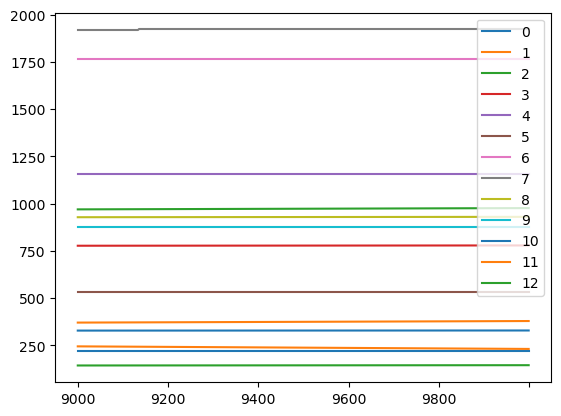

In [70]:
result_prices.plot()

<Axes: >

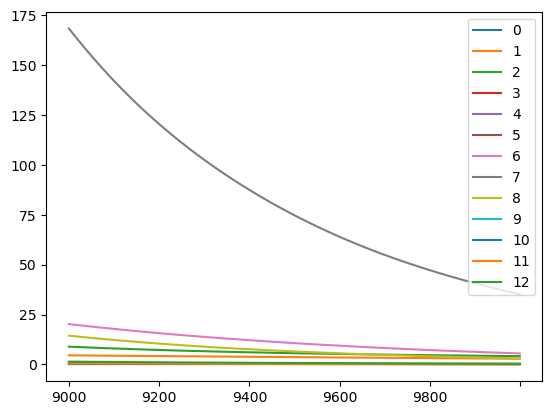

In [71]:
result_penalty.plot()